# HW3: Variational Autoencoders
**Meng Linghui**  

mengreinhold@163.com

## 1 VAE in 2D
### Part A

In this problem, you will investigate when a VAE places information into its latent code. Run this snippet generate two datasets: 

In [36]:
import numpy as np
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


**Train one VAE in this configuration on both datasets:**  
• 2D latent variables z with a standard normal prior $p(z) = N(z;0,I)$.   
• An approximate posterior $q_\theta(z|x) = N(z;\mu_\theta(x),\sigma_\theta(x))$, where $\mu_\theta(x)$ is a mean vector and $\sigma_\theta(x)$ and is a diagonal covariance matrix   
• A decoder $p_\theta(x|z) = N(x;\mu_\theta(z),\sigma_\theta(z))$, where $\mu_\theta(z)$ is a mean vector and $\sigma_\theta(z)$ and is a diagonal covariance matrix 

### show the sample data

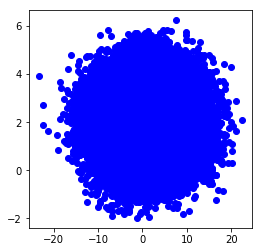

In [35]:
import matplotlib.pyplot as plt
x = sample_data_1()
plt.figure(figsize=(4,4))
plt.plot(x[:,0],x[:,1],'bo')
plt.show()

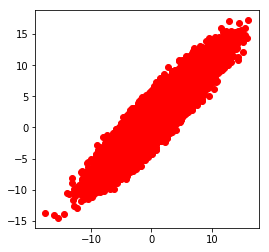

In [87]:
y = sample_data_2()
plt.figure(figsize=(4,4))
plt.plot(y[:,0], y[:,1], 'ro')
plt.show()

In [14]:
def sample_from_q_theta_z_x(x): # encoder
    mu = np.mean(x, axis=0)
    sigma = np.cov(x, rowvar=False)
    z = np.random.normal(mu, sigma, 100000)
    return z
def sample_from_p_theta_x_z(z): # decoder
    mu = np.mean(z, axis=0)
    sigma = np.cov(z, rowvar=False)
    x = np.random.normal(mu, sigma, 100000)
    return x

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [50]:
x = sample_data_1()
# z = np.random.multivariate_normal([0,0], [[1, 1],[1, 1]], 100000)
# x = np.hstack((x, z))
x = torch.from_numpy(x)
training_set = x[:int(len(x)*0.6)] 
val_set = x[int(len(x)*0.6):int(len(x)*0.8)]
test_set = x[int(len(x)*0.8):]

### Hyper-param

In [52]:
batch_size = 20
epochs = 30

In [83]:
class SimpleVAE(nn.Module):
    def __init__(self, var_dim):
        super(SimpleVAE, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=32)
        self.enc_mean = nn.Linear(in_features=32, out_features=8)
        self.enc_logvar = nn.Linear(in_features=32, out_features=var_dim)
        self.dec1 = nn.Linear(in_features=8, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=2)
        self.mse = nn.MSELoss()
        
    def encoder(self, x):
        x = x.type(torch.FloatTensor)
        h1 = F.relu(self.fc1(x))
        return self.enc_mean(h1), self.enc_logvar(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decoder(self, x):
        h2 = F.relu(self.dec1(x))
        return self.dec2(h2)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    
    def loss_function(self, true_x):
        batch_size = len(true_x)
        x, mu, logvar = self.forward(true_x)
        x = x.type(torch.DoubleTensor)
        
        if self.training:
            MSE = 0
            for datapoint in true_x:
                MSE += self.mse(datapoint, x)
            MSE = MSE / len(true_x)
        else:
            MSE = self.mse(true_x, x)
        
        KLD = -0.5*torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar))
        KLD /= (batch_size * 2)
        
        return MSE + KLD

In [84]:
net = SimpleVAE(1)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0001)
for param in net.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([32, 2])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([8, 32])
<class 'torch.Tensor'> torch.Size([8])
<class 'torch.Tensor'> torch.Size([1, 32])
<class 'torch.Tensor'> torch.Size([1])
<class 'torch.Tensor'> torch.Size([32, 8])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([2, 32])
<class 'torch.Tensor'> torch.Size([2])


In [88]:
import warnings

warnings.filterwarnings('ignore')

Epoch 0: loss 13.22603953842621 val_loss 10.208075580809155 
Epoch 10: loss 16.98896396998736 val_loss 14.249209144124393 
Epoch 20: loss 11.654572771110406 val_loss 16.559673371136988 


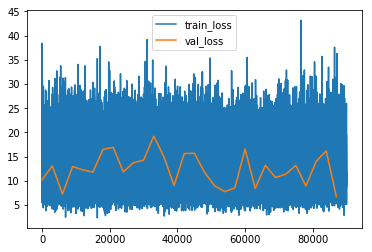

In [89]:
train_iter = torch.utils.data.DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
val_set_iter = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0
    
    for train_batch in train_iter:
        loss = net.loss_function(train_batch)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        
    with torch.set_grad_enabled(False):
        val_batch = next(iter(val_set_iter))
        val_loss = net.loss_function(val_batch)
        val_losses.append(val_loss.data.numpy())
        
    if epoch % 10 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))
        
import matplotlib.pyplot as plt
plt.plot(losses, label='train_loss')
plt.plot(np.arange(0, len(losses), int(len(losses)/len(val_losses))), val_losses, label='val_loss')
plt.legend()
plt.show()

## Part B

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

In [2]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm].astype(np.float32), data_y[perm]

(-5, 5, -5, 5)

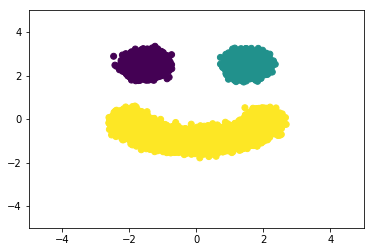

In [10]:
data_x, data_y = sample_data_3()
plt.figure()
plt.scatter(data_x[:,0], data_x[:,1], c=data_y)
plt.axis((-5,5,-5,5))

### dataset

In [5]:
class DataSet:

    def __init__(self,X):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        
        self.images = X

    def __len__(self):
        """return number of points in our dataset"""

        return len(self.images)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """

        img = self.images[idx]

        return img

In [12]:
c = torch.FloatTensor(data_x)
data_c_train = DataSet(torch.FloatTensor(c[0:int(0.8*len(data_x))]))
data_c_val = DataSet(torch.FloatTensor(c[int(0.8*len(data_x)):int(0.9*len(data_x))]))
data_c_test = DataSet(torch.FloatTensor(c[int(0.9*len(data_x)):]))


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import softplus

In [15]:
class DeterministicWarmup(object):
    """
    Linear deterministic warm-up as described in
    [Sønderby 2016].
    """
    def __init__(self, start_epochs=0, max_epochs=100, t_max=1):
        self.t = 0
        self.t_max = t_max
        self.inc = 1/max_epochs
        self.start_epochs=start_epochs

    def __iter__(self):
        return self

    def __next__(self, epoch):
        if epoch>=self.start_epochs:
            t = self.t + self.inc
            self.start_epochs +=1
            self.t = self.t_max if t > self.t_max else t
        return self.t

In [30]:
def log_normal(x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2*np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * torch.exp(log_var) + eps)

### Hyper-param

In [22]:
import torch
import torch.nn as nn
from torch.nn.functional import softplus
from torch import optim
import torch.nn.functional as F

# define size variables
num_features = 2
latent_features=2
num_samples=1
scalar = False
epochs=1000

warmup = DeterministicWarmup(max_epochs=25)

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples, scalar, beta=warmup ):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
        self.scalar = scalar
        self.beta = beta
        self.out_features = self.latent_features+1  if self.scalar else 2*self.latent_features

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=(self.latent_features*2))
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=self.out_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector      
        q_mu, q_log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        q_mu = q_mu.unsqueeze(1)
        q_log_var = q_log_var.unsqueeze(1)

        # :- Reparametrisation trick
        z = self.Reparametrisation(q_mu,q_log_var,self.num_samples)  


        # Run through decoder and sample reconstruction
        x_sample = self.decoder(z)

        # split in 2 parts
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        outputs["x_hat"] = self.Reparametrisation(x_mu,x_log_var,1)  
        outputs["z"] = z
        outputs["mu"] =q_mu
        outputs["log_var"] = q_log_var
        outputs["x_mu"] = x_mu
        outputs["x_log_var"] = x_log_var

        return outputs

    def Reparametrisation(self,mu, log_var, num_samples):
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)

        # Don't propagate gradients through randomness
        
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, num_samples, self.latent_features)

        sigma = torch.exp(0.5*log_var)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        if len(mu.shape)<3:
            z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)  
        else:
            z = mu + epsilon * sigma  

        return z
    
    def sample(self, z):
        """
        Given z ~ N(0, I) generates a sample from
        the learned distribution based on p_θ(x|z).
        :param z: (torch.autograd.Variable) Random normal variable
        :return: (torch.autograd.Variable) generated sample
        """
        if len(z.shape)<3:
            z = z.unsqueeze(1)
        x_sample = self.decoder(z)
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        full_generation_path = self.Reparametrisation(x_mu,x_log_var,1)  
        without_decoder_noise = x_mu
        return full_generation_path, without_decoder_noise

    def loss_function(self, t, q_mu, q_log_var, x_mu, x_log_var, z, epoch):
        # Reconstruction error, log[p(x|z)]
        # Sum over features
        t = t.unsqueeze(1)

        #likelihood = F.mse_loss(y,t,reduction='none')
        #likelihood = likelihood.view(likelihood.size(0),-1).sum(1)
        #log_pxz = log_normal, rec loss
        likelihood = torch.mean(torch.sum(-log_normal(t,x_mu,x_log_var),dim=2),dim=1)
        # regularization error:
        p_mu, p_log_var = torch.zeros_like(q_mu), torch.ones_like(q_log_var)

        log_qz = log_normal(z, q_mu, q_log_var)
        log_pz = log_normal(z, p_mu, p_log_var)
        kl = torch.mean(torch.sum(log_qz - log_pz,dim=2),dim=1)

        # Regularization error: 
        # Kulback-Leibler divergence between approximate posterior, q(z|x)
        # and prior p(z) = N(z | mu, sigma*I).
        
        # In the case of the KL-divergence between diagonal covariance Gaussian and 
        # a standard Gaussian, an analytic solution exists. Using this excerts a lower
        # variance estimator of KL(q||p)
        #kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

        # Combining the two terms in the evidence lower bound objective (ELBO) 
        # mean over batch
        nll = torch.mean(likelihood)/np.log(2)/2
        kl = torch.mean(kl)/np.log(2)/2
        self.beta.__next__(epoch)
        ELBO = nll + self.beta.t*kl
        
        # notice minus sign as we want to maximise ELBO
        return ELBO, kl, nll

def log_normal(x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2*np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * torch.exp(log_var) + eps)

In [23]:
net = VariationalAutoencoder(latent_features, 13, scalar, beta= warmup)
x = c[0:1000]
outputs = net.forward(x)

mu, log_var = outputs["mu"], outputs["log_var"]
x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
z = outputs["z"]
x = x.reshape(1000, 1, 2)

loss, kl, nll = net.loss_function(x, mu, log_var, x_mu, x_log_var, z, 1)

print(loss)

tensor(23.1366, grad_fn=<AddBackward0>)


In [24]:
warmup = DeterministicWarmup(start_epochs=0, max_epochs=500)
net = VariationalAutoencoder(latent_features, 1, False, beta=warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [26]:
def fit(data_a_train, data_a_val, data_a_test, epochs=50):

    losses, val_losses =[],[]
    batch_size = 1000

    train_iter = torch.utils.data.DataLoader(dataset=data_a_train,batch_size=batch_size,shuffle=True)
    val_iter = torch.utils.data.DataLoader(dataset=data_a_val,batch_size=batch_size,shuffle=True)
    test_iter = torch.utils.data.DataLoader(dataset=data_a_test,batch_size=batch_size,shuffle=True)


    losses = []
    val_losses = []
    val_losses100 = []
    kls = []
    val_kls = []
    val_kls100 = []
    nlls = []
    val_nlls = []
    val_nlls100 = []

    for epoch in range(epochs):
        net.num_samples=1
        net.train()

        loss = 0
        
        for train_X in train_iter:
            
            outputs = net(train_X)
            
            x_hat = outputs["x_hat"]
            mu, log_var = outputs["mu"], outputs["log_var"]
            x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
            z = outputs["z"]
            
            loss, kl, nll = net.loss_function(train_X, mu, log_var,x_mu, x_log_var,z, epoch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.data.numpy())
            kls.append(kl.data.numpy())
            nlls.append(nll.data.numpy())

            
        with torch.set_grad_enabled(False):
            net.eval()

            for val_X in val_iter:
                
                outputs = net(val_X)

                x_hat = outputs["x_hat"]
                mu, log_var = outputs["mu"], outputs["log_var"]
                x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
                z = outputs["z"]

                val_loss, val_kl, val_nll = net.loss_function(val_X, mu, log_var, x_mu, x_log_var, z, epoch)

                val_losses.append(val_loss.data.numpy())
                val_kls.append(val_kl.data.numpy())
                val_nlls.append(val_nll.data.numpy())

        with torch.set_grad_enabled(False):
            net.num_samples=100
            net.eval()

            for val_X in val_iter:
                
                outputs = net(val_X)

                x_hat = outputs["x_hat"]
                mu, log_var = outputs["mu"], outputs["log_var"]
                x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
                z = outputs["z"]

                val_loss, val_kl, val_nll = net.loss_function(val_X, mu, log_var, x_mu, x_log_var, z, epoch)

                val_losses100.append(val_loss.data.numpy())
                val_kls100.append(val_kl.data.numpy())
                val_nlls100.append(val_nll.data.numpy())

        if epoch % 20 ==0:
            print('Epoch {}: loss {} | kl {} | nll {} '.format(epoch,loss.item(),kl.item(),nll.item()))

    test_losses = []
    test_kls = []
    test_nlls = []
    for test_X in test_iter:
    
        outputs = net(test_X)

        x_hat = outputs["x_hat"]
        mu, log_var = outputs["mu"], outputs["log_var"]
        x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
        z = outputs["z"]

        test_loss, test_kl, test_nll = net.loss_function(test_X, mu, log_var, x_mu, x_log_var, z, epoch)

        test_losses.append(test_loss.data.numpy())
        test_kls.append(test_kl.data.numpy())
        test_nlls.append(test_nll.data.numpy())


    print('test loss {}  test kl {} test nll {} '.format(np.mean(test_losses),np.mean(test_kls),np.mean(test_nlls)))
    import matplotlib.pyplot as plt
    f, axarr = plt.subplots(1,3, figsize=(18,6))

    ax = axarr[0]
    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "ELBO_val_loss")

    ax = axarr[1]
    ax.set_title('KL')
    ax.plot(kls, label = "kl_train_loss")
    ax.plot(np.arange(0, len(kls),(len(kls)/len(val_kls))),val_kls, label = "KL_val_loss")

    ax = axarr[2]
    ax.set_title('NLL')
    ax.plot(nlls, label = "NLL_train_loss")
    ax.plot(np.arange(0, len(nlls),(len(nlls)/len(val_nlls))),val_nlls, label = "NLL_val_loss")
    plt.show()

    import matplotlib.pyplot as plt
    f, ax = plt.subplots(1,1, figsize=(9,6))

    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "IWAE 1")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses100))),val_losses100, label = "IWAE 100")
    plt.show()


Epoch 0: loss -1.3871210813522339 | kl 8.075689315795898 | nll -1.4032725095748901 
Epoch 20: loss -1.3470373153686523 | kl 7.363991737365723 | nll -1.6563249826431274 
Epoch 40: loss -1.8310472965240479 | kl 6.240138530731201 | nll -2.342738628387451 
Epoch 60: loss 0.22907596826553345 | kl 7.808665752410889 | nll -0.7235812544822693 
Epoch 80: loss -1.7935525178909302 | kl 6.171352386474609 | nll -2.793311595916748 
Epoch 100: loss -2.840470314025879 | kl 7.396803855895996 | nll -4.334624767303467 
Epoch 120: loss -2.153674602508545 | kl 6.7657856941223145 | nll -3.790994644165039 
Epoch 140: loss -2.4919257164001465 | kl 7.391420364379883 | nll -4.576306343078613 
Epoch 160: loss -2.093242645263672 | kl 7.070245265960693 | nll -4.369861602783203 
Epoch 180: loss -1.6247127056121826 | kl 6.6450018882751465 | nll -4.030203342437744 
Epoch 200: loss -1.5846829414367676 | kl 7.047863960266113 | nll -4.417924404144287 
Epoch 220: loss -1.620492935180664 | kl 7.232606410980225 | nll -4.81

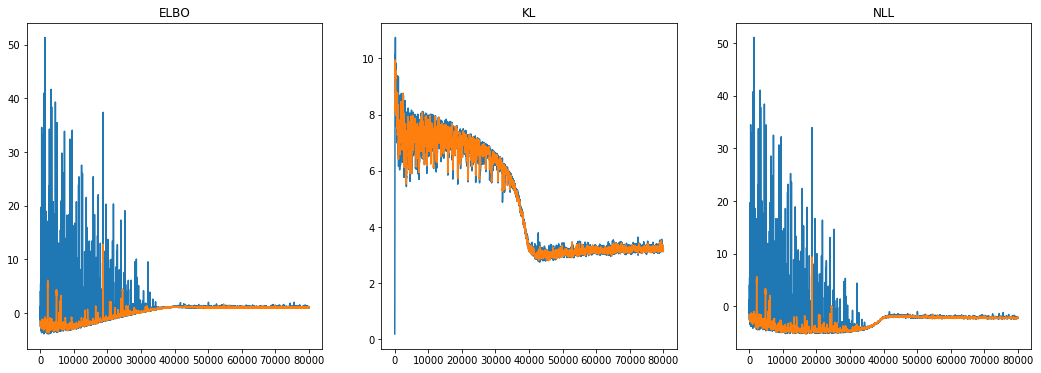

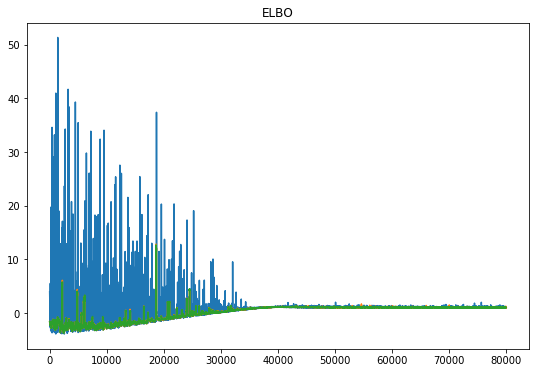

In [27]:
fit(data_c_train, data_c_val, data_c_test, epochs=1000)

In [28]:
def plotter(a_new,y):
    f, axarr = plt.subplots(2,2, figsize=(14,8))
    net.num_samples=1
    net.eval()
    z = torch.randn(1000, 2)
    full_generation_path, without_decoder_noise = net.sample(z)
    full_generation_path = full_generation_path.data.numpy() 
    without_decoder_noise = without_decoder_noise.data.numpy()
    x_rec = net.forward(a_new[0:1000])['x_hat'].data.numpy()
    # Split encoder outputs into a mean and variance vector      
    mu, log_var = torch.chunk(net.encoder(a_new[0:1000]), 2, dim=-1)
    z = net.Reparametrisation(mu,log_var,1)

    x_rec = x_rec.squeeze(1)
    full_generation_path = full_generation_path.squeeze(1)
    without_decoder_noise = without_decoder_noise.squeeze(1)
    z = z.squeeze(1)
    
    ax = axarr[0][0]
    ax.set_title('Reconstruced samples')
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(x_rec[:,0],x_rec[:,1], c=y[:1000])
    ax.axis('equal')

    ax = axarr[0][1]
    ax.set_title('latent space')
    ax.scatter(z[:,0].data.numpy(),z[:,1].data.numpy(),c=y[:1000])
    ax.axis('equal')

    ax = axarr[1][0]
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(full_generation_path[:,0],full_generation_path[:,1])
    ax.set_title('samples using full generation path from latent space')
    ax.axis('equal')

    ax = axarr[1][1]
    ax.scatter(a_new[:1000,0].data.numpy(),a_new[:1000,1].data.numpy())
    ax.scatter(without_decoder_noise[:,0],without_decoder_noise[:,1])
    ax.set_title('samples without decoder noise from latent space')
    ax.axis('equal')
    plt.show()


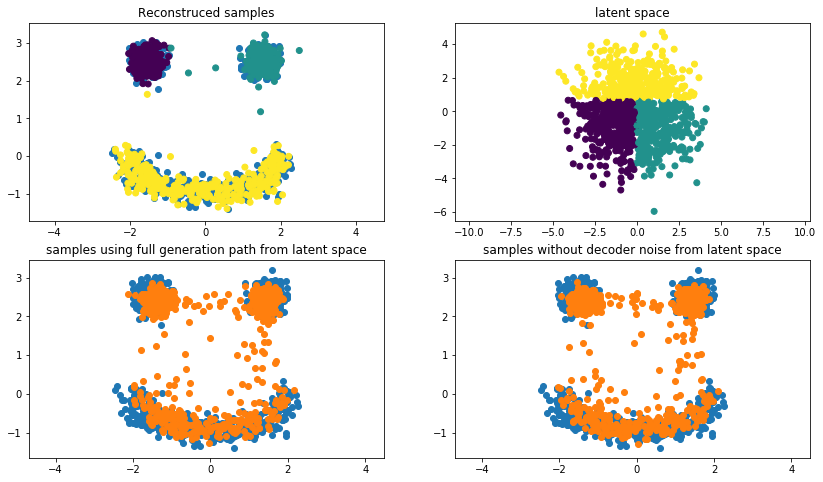

In [29]:
plotter(c, data_y)

## High-dimentional data

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

In [50]:
with open('hw3-q2.pkl', 'rb') as f:
    data = pickle.load(f)

In [51]:
train = data['train']
val = data['valid']
test = data['test']

In [52]:
train[0].shape

(32, 32, 3)

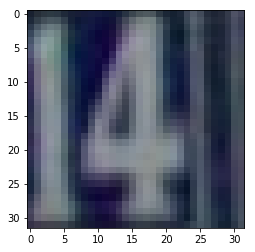

In [53]:
plt.imshow(train[0])

In [54]:
import torch
import numpy as np
data_a_train = DataSet(torch.FloatTensor(train[:1000]).permute(0,3,1,2).cuda())
data_a_val = DataSet(torch.FloatTensor(val[:1000]).permute(0,3,1,2).cuda())
data_a_test = DataSet(torch.FloatTensor(test[:1000]).permute(0,3,1,2).cuda())

In [55]:
example = np.array(next(iter(data_a_train)).permute(1,2,0).cpu(),dtype='uint8')
print(example.shape)

(32, 32, 3)


In [56]:
example.dtype

dtype('uint8')

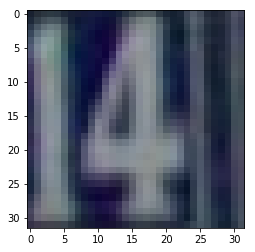

In [57]:
plt.imshow(example)

In [58]:
class DeterministicWarmup(object):
    """
    Linear deterministic warm-up as described in
    [Sønderby 2016].
    """
    def __init__(self, start_epochs=0, max_epochs=100, t_max=1):
        self.t = 0
        self.t_max = t_max
        self.inc = 1/max_epochs
        self.start_epochs=start_epochs

    def __iter__(self):
        return self

    def __next__(self, epoch):
        if epoch>=self.start_epochs:
            t = self.t + self.inc
            self.start_epochs +=1
            self.t = self.t_max if t >= self.t_max else t
        return self.t

In [59]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.functional import softplus

warmup = DeterministicWarmup(max_epochs=25)

In [60]:
class gated_shortcut_connection(nn.Module):
    def __init__(self, channels=16):
        super(gated_shortcut_connection, self).__init__()
        
        self.channels = channels
        
        self.A = nn.Conv2d(self.channels, self.channels**2, 1, stride=1, padding=0)
        self.B = nn.Conv2d(self.channels, self.channels**2, 1, stride=1, padding=0)
        self.channels = channels
    def forward(self, x):
        A = self.A(x)
        B = self.B(x)
        shortcut = torch.mul(A, torch.sigmoid(B + 1e-5))
        return shortcut

In [62]:
class ResidualBlock(nn.Module):
    def __init__(self, channels=32):
        super(ResidualBlock, self).__init__()
        
        self.channels = channels
        
        self.layers = nn.Sequential(
        nn.ReLU(), 
        nn.Conv2d(self.channels, self.channels//4, kernel_size=3, padding=1), 
        nn.ReLU(), 
        nn.Conv2d(self.channels//4, self.channels//2, kernel_size=3, padding=1), 
        gated_shortcut_connection()
        )
    
    def forward(self, x):
        return self.layers(x) + x
    
class Residual_stack(nn.Module):
    def __init__(self, sum_blocks=5, channels=32):
        super(Residual_stack, self).__init__()
        
        self.channels = channels
        self.layers = nn.Sequential(*[ResidualBlock() for _ in range(num_blocks)])
    
    def forward(self, x):
        return F.relu(self.layers(x))

In [63]:
class Residual_stack(nn.Module):
    def __init__(self, channels=32):

        super(Residual_stack, self).__init__()

        self.channels = channels

        self.layers = []
        
        for _ in range(5):
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Conv2d(self.channels,4, 3, stride=1, padding=1))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Conv2d(4,int(self.channels/2), 3, stride=1, padding=1))
            self.layers.append(gated_shortcut_connection(channels = int(self.channels/2)))

        self.layers.append(nn.ReLU())
        self.total_layer = nn.Sequential(*self.layers)

    def forward(self,x):
        out = self.total_layer(x) + x
        return out

In [65]:
class Stochastic(nn.Module):
    """
    Base stochastic layer that uses the
    reparametrization trick [Kingma 2013]
    to draw a sample from a distribution
    parametrised by mu and log_var.
    """

    def reparametrize(self,mu, log_var, num_samples):
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)

        # Don't propagate gradients through randomness
        
        with torch.no_grad():

            epsilon = torch.randn(num_samples,*mu.shape).cuda()

        sigma = torch.exp(0.5*log_var)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu + epsilon * sigma

        return z

class GaussianSample(Stochastic):
    """
    Layer that represents a sample from a
    Gaussian distribution.
    """
    def __init__(self, num_samples):
        super(GaussianSample, self).__init__()
        self.num_samples = num_samples

    def forward(self, mu, log_var):

        return self.reparametrize(mu, log_var, self.num_samples), mu, log_var

In [66]:
import torch.nn as nn
import torch

class TotalNetwork(nn.Module):
    def __init__(self,channels=16, num_samples=1, beta=warmup):

        super(TotalNetwork,self).__init__()
        self.channels = channels
        self.num_samples = num_samples
        self.beta = beta

         # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3,self.channels, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.channels,self.channels*2, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.channels*2,self.channels*2, 3, stride=1, padding=1),
            Residual_stack(channels = self.channels*2),
            nn.Conv2d(self.channels*2,self.channels*4, 3, stride=1, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.channels*2,self.channels*2, 3, stride=1, padding=1),
            Residual_stack(channels= self.channels*2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels*2,self.channels, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels, 3*2, 4, stride=2, padding=1),
        )

        self.Reparametrisation = GaussianSample(self.num_samples)
        self.reconstruct_sample = GaussianSample(1)


    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector     
        x = self.encoder(x)

        mu, log_var = torch.chunk(x, 2, dim=1)


        # :- Reparametrisation trick
        z, q_mu, q_log_var = self.Reparametrisation(mu,log_var)  
        _,rgb,ch,w,h=z.shape
        z = z.reshape(-1,ch,w,h)

        # Run through decoder and sample reconstruction
        x_sample = self.decoder(z)

        # split in 2 parts
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=1)

        x_hat, x_mu, x_log_var = self.reconstruct_sample(x_mu,x_log_var)  
        x_hat = x_hat.squeeze(0)

        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] =q_mu
        outputs["log_var"] = q_log_var
        outputs["x_mu"] = x_mu
        outputs["x_log_var"] = x_log_var

        return outputs
    
    def sample(self, z):
        """
        Given z ~ N(0, I) generates a sample from
        the learned distribution based on p_θ(x|z).
        :param z: (torch.autograd.Variable) Random normal variable
        :return: (torch.autograd.Variable) generated sample
        """
        if len(z.shape)<3:
            z = z.unsqueeze(1)
        x_sample = self.decoder(z)
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        full_generation_path = self.Reparametrisation(x_mu,x_log_var,1)  
        without_decoder_noise = x_mu
        return full_generation_path, without_decoder_noise

    def loss_function(self, t, q_mu, q_log_var, x_mu, x_log_var, z, epoch):
        # Reconstruction error, log[p(x|z)]
        # Sum over features

        #likelihood = F.mse_loss(y,t,reduction='none')
        #likelihood = likelihood.view(likelihood.size(0),-1).sum(1)
        #log_pxz = log_normal, rec loss

        likelihood = torch.mean(torch.sum(-log_normal(t,x_mu,x_log_var),dim=1),dim=(1,2))
        # regularization error:
        p_mu, p_log_var = torch.zeros_like(q_mu), torch.ones_like(q_log_var)

        log_qz = log_normal(z, q_mu, q_log_var)
        log_pz = log_normal(z, p_mu, p_log_var)
        kl = torch.mean(torch.sum(log_qz - log_pz,dim=1),dim=(1,2))

        # Regularization error: 
        # Kulback-Leibler divergence between approximate posterior, q(z|x)
        # and prior p(z) = N(z | mu, sigma*I).
        
        # In the case of the KL-divergence between diagonal covariance Gaussian and 
        # a standard Gaussian, an analytic solution exists. Using this excerts a lower
        # variance estimator of KL(q||p)
        #kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

        # Combining the two terms in the evidence lower bound objective (ELBO) 
        # mean over batch
        nll = torch.mean(likelihood)/np.log(2)/(32*32*3)
        kl = torch.mean(kl)/np.log(2)/(32*32*3)
        print(nll)
        self.beta.__next__(epoch)
        ELBO = nll + kl #self.beta.t*kl
        
        # notice minus sign as we want to maximise ELBO
        return ELBO, kl, nll

def log_normal(x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2*np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * torch.exp(log_var) + eps)
        

In [67]:
net = TotalNetwork().cuda()

In [68]:
def fit(data_a_train, data_a_val, data_a_test, epochs=50):
    import matplotlib.pyplot as plt

    losses, val_losses =[],[]
    batch_size = 1000

    train_iter = torch.utils.data.DataLoader(dataset=data_a_train,batch_size=batch_size)
    val_iter = torch.utils.data.DataLoader(dataset=data_a_val,batch_size=batch_size)
    test_iter = torch.utils.data.DataLoader(dataset=data_a_test,batch_size=batch_size)


    losses = []
    val_losses = []
    val_losses100 = []
    kls = []
    val_kls = []
    val_kls100 = []
    nlls = []
    val_nlls = []
    val_nlls100 = []

    for epoch in range(epochs):
        net.num_samples=1
        net.train()

        loss = 0
        
        for train_X in train_iter:
            
            outputs = net(train_X.cuda())
            
            x_hat = outputs["x_hat"]
            mu, log_var = outputs["mu"], outputs["log_var"]
            x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
            z = outputs["z"]
            
            loss, kl, nll = net.loss_function(train_X, mu, log_var,x_mu, x_log_var,z, epoch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.cpu().data.numpy())
            kls.append(kl.cpu().data.numpy())
            nlls.append(nll.cpu().data.numpy())

            
        with torch.set_grad_enabled(False):
            net.eval()

            for val_X in val_iter:
                
                outputs = net(val_X.cuda())

                x_hat = outputs["x_hat"]
                mu, log_var = outputs["mu"], outputs["log_var"]
                x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
                z = outputs["z"]

                val_loss, val_kl, val_nll = net.loss_function(val_X, mu, log_var, x_mu, x_log_var, z, epoch)

                val_losses.append(val_loss.cpu().data.numpy())
                val_kls.append(val_kl.cpu().data.numpy())
                val_nlls.append(val_nll.cpu().data.numpy())


        if epoch % 10 ==0:
            print('Epoch {}: loss {} kl {} nll {} '.format(epoch,loss.item(),kl.item(),nll.item()))
            #plot an example
            x = val_X[0:1]
            output = net.forward(x)
            print(x.shape)
            example = np.array(x.squeeze(0).permute(1,2,0).cpu(),dtype='uint8')
            plt.imshow(example)
            plt.show()
            out = output['x_hat'].squeeze(0).permute(1,2,0).cpu().detach()
            v = np.array(out,dtype='uint8')
            plt.imshow(v)
            plt.show()



    test_losses = []
    test_kls = []
    test_nlls = []
    for test_X in test_iter:
    
        outputs = net(test_X)

        x_hat = outputs["x_hat"]
        mu, log_var = outputs["mu"], outputs["log_var"]
        x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
        z = outputs["z"]

        test_loss, test_kl, test_nll = net.loss_function(test_X, mu, log_var, x_mu, x_log_var, z, epoch)

        test_losses.append(test_loss.cpu().data.numpy())
        test_kls.append(test_kl.cpu().data.numpy())
        test_nlls.append(test_nll.cpu().data.numpy())


    print('test loss {}  test kl {} test nll {} '.format(np.mean(test_losses),np.mean(test_kls),np.mean(test_nlls)))
    import matplotlib.pyplot as plt
    f, axarr = plt.subplots(1,3, figsize=(18,6))

    ax = axarr[0]
    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "ELBO_val_loss")

    ax = axarr[1]
    ax.set_title('KL')
    ax.plot(kls, label = "kl_train_loss")
    ax.plot(np.arange(0, len(kls),(len(kls)/len(val_kls))),val_kls, label = "KL_val_loss")

    ax = axarr[2]
    ax.set_title('NLL')
    ax.plot(nlls, label = "NLL_train_loss")
    ax.plot(np.arange(0, len(nlls),(len(nlls)/len(val_nlls))),val_nlls, label = "NLL_val_loss")
    plt.show()

    import matplotlib.pyplot as plt
    f, ax = plt.subplots(1,1, figsize=(9,6))

    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "IWAE 1")
    plt.show()


In [ ]:
warmup = DeterministicWarmup(start_epochs=0,max_epochs=100)
net = TotalNetwork( beta = warmup).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4)
fit(data_a_train, data_a_val, data_a_test,epochs = 200)

**There is not enough GPU memory left**

In [71]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image as Image

  Running setup.py bdist_wheel for Pillow: started
  Running setup.py bdist_wheel for Pillow: finished with status 'error'
  Complete output from command C:\Users\Reinhold\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\Reinhold\\AppData\\Local\\Temp\\pip-install-_nxqeuv5\\Pillow\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\Reinhold\AppData\Local\Temp\pip-wheel-b937cqn_ --python-tag cp37:
  Single threaded build for windows
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.7
  creating build\lib.win-amd64-3.7\PIL
  copying PIL\BdfFontFile.py -> build\lib.win-amd64-3.7\PIL
  copying PIL\BmpImagePlugin.py -> build\lib.win-amd64-3.7\PIL
  copying PIL\BufrStubImagePlugin.py -> build\lib.win-amd64-3.7\PIL
  copying PIL\ContainerIO.py -> build\lib.win-amd64-3.7\PIL
  copying PIL\CurImagePlu

  Failed building wheel for Pillow
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
torchvision 0.4.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
scikit-image 0.14.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
Command "C:\Users\Reinhold\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\Reinhold\\AppData\\Local\\Temp\\pip-install-_nxqeuv5\\Pillow\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\Reinhold\AppData\Local\Temp\pip-record-1fst40p2\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\Reinhold\AppData\Local\Temp\pip-install-_nxqeuv5\Pillow\
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Running setup.py bdist_wheel for image: started
  Running setup.py bdist_wheel for image: finished with status 'done'
  Stored in directory: C:\Users\Reinhold\AppData\Local\pip\Cache\wheels\17\c3\b2\0435a955f6cf071224a9b226071e9798dc2289dd9b37115fc6
Successfully built image


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Train: (65931, 32, 32, 3)
Val:   (7326, 32, 32, 3)
Test:  (26032, 32, 32, 3)
Transformed data size: torch.Size([64, 3, 16, 16])


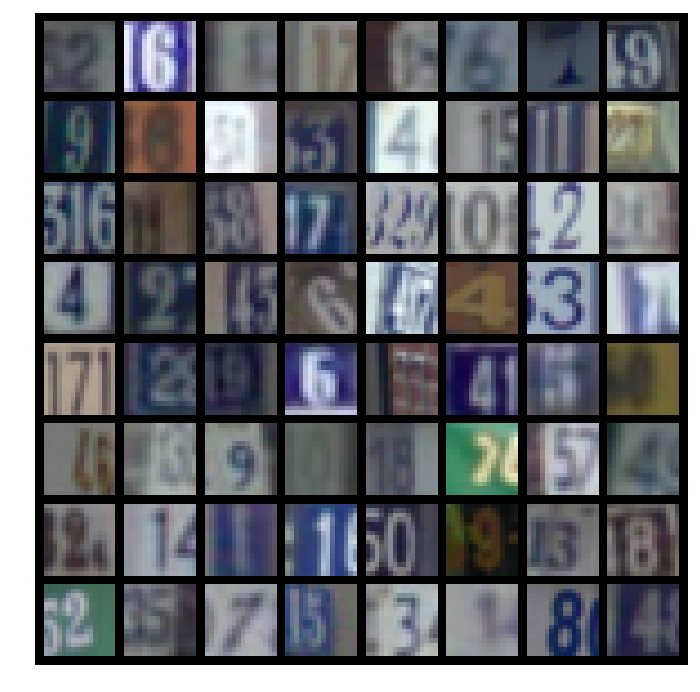

In [73]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
%matplotlib inline
sns.set(style='darkgrid')
with open('hw3-q2.pkl','rb') as f:
    data = pickle.load(f)
#data = pkl.load(open('drive/My Drive/Colab Notebooks/hw3-q2.pkl', 'rb'))
data_train, data_val, data_test = data['train']/255, data['valid']/255, data['test']/255
print(f'Train: {data_train.shape}\nVal:   {data_val.shape}\nTest:  {data_test.shape}')

def show(img, renorm=False, nrow=8):
  img_grid = torchvision.utils.make_grid(img, nrow=nrow).numpy()
  plt.figure(figsize=(12,12))
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')
  plt.show()

transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(size=(16, 16)),
  transforms.ToTensor()
])

class ImgDataset(Dataset):
  def __init__(self, X):
    self.X = torch.Tensor(X).permute(0, 3, 1, 2)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return transform(self.X[idx]).cuda()

batch_size = 64
dl_train = DataLoader(ImgDataset(data_train), batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ImgDataset(data_val), batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ImgDataset(data_test), batch_size=batch_size, shuffle=True)

output = next(iter(dl_train))
print(f'Transformed data size: {output.size()}')
show(output.cpu())

In [74]:
def evaluate_img(net, dl_test, losses, schedule):
  net.eval()
  loss, nll, kl = losses

  data_batch = next(iter(dl_test))

  recon, recon_z, _, _, _, _ = net(data_batch)
  recon = recon.detach().cpu()
  recon_z = recon_z.detach().cpu()

  z = torch.randn_like(recon_z).cuda()
  samples, _, _ = net.decoder(z)
  samples = samples.detach().cpu()

  samples2, _, _ = net.decoder(z, do_reparam=False)
  samples2 = samples2.detach().cpu()

  betas = [schedule[i] for i in range(len(loss))]

  plt.figure(figsize=(16, 8))

  plt.subplot(2, 4, 1)
  plt.plot(range(len(nll)), (nll/np.log(2))/2)
  plt.title('NLL (bits/dim)')

  plt.subplot(2, 4, 2)
  plt.plot(range(len(kl)), kl)
  plt.title('KL-divergence')

  plt.subplot(2, 4, 3)
  plt.plot(range(len(loss)), loss)
  plt.title('ELBO')

  plt.subplot(2, 4, 4)
  plt.plot(range(len(betas)), betas)
  plt.title('Weight on KL-term (beta)')

  plt.subplot(2, 4, 5)
  plt.title('Original samples')
  img_grid = torchvision.utils.make_grid(data_batch, nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.subplot(2, 4, 6)
  plt.title('Reconstruction')
  img_grid = torchvision.utils.make_grid(torch.clamp(recon, min=0, max=1), nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.subplot(2, 4, 7)
  plt.title('Latent space')
  img_grid = torchvision.utils.make_grid(torch.clamp(recon_z, min=0, max=1), nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.subplot(2, 4, 8)
  plt.title('Samples (with decoder noise)')
  img_grid = torchvision.utils.make_grid(torch.clamp(samples, min=0, max=1), nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.show()
  print('\n\n')

In [75]:
class BetaWarmup():
  def __init__(self, num_epochs=200):
    if num_epochs is None or num_epochs < 1:
      self.schedule = [1]
    else:
      self.schedule = np.linspace(0, 1, num_epochs)

  def __getitem__(self, item):
    try:
      #return 0.01
      return self.schedule[item]
    except:
      return 1


class GatedShortcutConnection(nn.Module):
  def __init__(self):
    super(GatedShortcutConnection, self).__init__()

    self.layers = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(num_filters//2, num_filters, kernel_size=3, padding=1)
    )

  def forward(self, x):
    return self.layers(x)


class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()

    self.layers = nn.Sequential(
      nn.ReLU(),
      nn.Conv2d(num_filters, num_filters//4, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(num_filters//4, num_filters//2, kernel_size=3, padding=1),
      GatedShortcutConnection()
    )

  def forward(self, x):
    return self.layers(x) + x


class ResidualStack(nn.Module):
  def __init__(self, num_blocks=5):
    super(ResidualStack, self).__init__()

    self.layers = nn.Sequential(*[ResidualBlock() for _ in range(num_blocks)])

  def forward(self, x):
    return F.relu(self.layers(x))


class ImgCoder(nn.Module):
  def __init__(self, encoder=None, decoder=None):
    super(ImgCoder, self).__init__()
    assert encoder is not None or decoder is not None

    self.num_colors = 3

    if encoder:
      self.layers = nn.Sequential(
        nn.Conv2d(self.num_colors, num_filters//2, kernel_size=4, stride=2, padding=9),
        nn.ReLU(),
        nn.Conv2d(num_filters//2, num_filters, kernel_size=4, stride=2, padding=9),
        nn.ReLU(),
        nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
        ResidualStack()
      )
      self.mu = nn.Linear(num_filters*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)
      self.log_var = nn.Linear(num_filters*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)

    elif decoder:
      self.layers = nn.Sequential(
        nn.Conv2d(self.num_colors, num_filters, kernel_size=3, stride=1, padding=1),
        ResidualStack(),
        nn.ConvTranspose2d(num_filters, num_filters//2, kernel_size=4, stride=2, padding=9),
        nn.ReLU(),
        nn.ConvTranspose2d(num_filters//2, self.num_colors, kernel_size=4, stride=2, padding=9)
      )
      self.mu = nn.Linear(self.num_colors*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)
      self.log_var = nn.Linear(self.num_colors*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)

  def reparam(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)

    return mu + eps * std

  def forward(self, x, do_reparam=True):
    x = self.layers(x)
    x = x.view(x.size(0), -1)

    mu = self.mu(x).view(x.size(0), self.num_colors, num_pixels, num_pixels)
    log_var = self.log_var(x).view(x.size(0), self.num_colors, num_pixels, num_pixels)

    if do_reparam:
      x = self.reparam(mu, log_var)
    else:
      x = mu

    return x, mu, log_var


class ImgVAE(nn.Module):
  def __init__(self):
    super(ImgVAE, self).__init__()

    self.encoder = ImgCoder(encoder=True)
    self.decoder = ImgCoder(decoder=True)

  def forward(self, x):
    if not isinstance(x, torch.Tensor):
      x = torch.Tensor(x).cuda()

    if not x.shape[1] == 3:
      x = x.permute(0, 3, 1, 2)

    z, z_mu, z_log_var = self.encoder(x)
    x, x_mu, x_log_var = self.decoder(z)

    return x, z, z_mu, z_log_var, x_mu, x_log_var

  def kl(self, z, mu, log_var):
    qz = log_pdf(z, mu, log_var)
    pz = log_standard_pdf(z)

    return qz - pz

  def elbo(self, x, outputs, beta):
    x_hat, z, z_mu, z_log_var, x_mu, x_log_var = outputs

    nll = -torch.mean(log_pdf(x, x_mu, x_log_var))
    kl = torch.mean(self.kl(z, z_mu, z_log_var))

    return nll + beta * kl, nll, kl


def log_standard_pdf(x):
  return torch.sum(-0.5 * np.log(2 * np.pi) - x**2 / 2, dim=(-3))

  
def log_pdf(x, mu, log_var):
  logs = -0.5 * np.log(2 * np.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
  return torch.sum(logs, dim=(-3))


num_filters = 256
num_pixels = 16

print('Initializing network...')
net = ImgVAE()

print('Moving network to GPU...')
net = net.cuda()

print('Running a forward pass...')
outputs = net(next(iter(dl_train)))

print('Done!')

Initializing network...
Moving network to GPU...
Running a forward pass...
Done!


In [ ]:
def fit_img(dl_train, num_epochs=50):
  net = ImgVAE().cuda()
  optimizer = optim.Adam(net.parameters())
  schedule = BetaWarmup(num_epochs//2)

  train_elbo, valid_elbo = [], []
  train_nll, valid_nll = [], []
  train_kl, valid_kl = [], []

  for epoch in range(num_epochs):

    net.train()
    batch_elbo, batch_nll, batch_kl = [], [], []

    for x in dl_train:

      outputs = net(x)
      elbo, nll, kl = net.elbo(x, outputs, schedule[epoch])

      optimizer.zero_grad()
      elbo.backward()
      optimizer.step()
      
      batch_elbo.append(elbo.item())
      batch_nll.append(nll.item())
      batch_kl.append(kl.item())

    train_elbo.append(np.mean(batch_elbo))
    train_nll.append(np.mean(batch_nll))
    train_kl.append(np.mean(batch_kl))

    print(f'Epoch {epoch+1}/{num_epochs}, ELBO: {train_elbo[-1]}, KL: {train_kl[-1]}')

    if epoch % 5 == 0:
      evaluate_img(net, dl_val, (np.array(train_elbo), np.array(train_nll), np.array(train_kl)), schedule)

  return net, (np.array(train_elbo), np.array(train_nll), np.array(train_kl)), schedule


net, losses, schedule = fit_img(dl_train, num_epochs=50)

**There is not enough GPU memory left**